# Coherence times  via Ramsey and Spin Echo experiments 

In our model, a qubit evolves via a discretized time-dependent Hamiltonian $h(t) =\frac{ \omega(t)}{2}Z$, 
with $t=t_s,\dots,N t_s$, where $t_s$ is the sampling time and acts as our unit of time in our code suite (i.e., $t_s=1$ in what follows.), and $N$ is the length of the time trace.

With pink noise, we consider time traces of the form $\omega(t)=2\pi \sqrt{S_0} g(t)$, where $g(t)$ is a normalized time trace associated with a Power-Spectral Density $S(f)=1/f$, where $f$ is the discretized frequency associated with the time vector $t$ introduced above, and $S_0$ is the spectral intensity (which has dimension of the square frequency, and is thus written in our code in units of $t_s^{-2}$)

In this notebook, we will study how an individual qubit is affected by such noise, in the context of Ramsey and spin echo experiments.


In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np

from spin_pulse import ExperimentalEnvironment, HardwareSpecs, Shape

num_qubits = 1
B_field, delta, J_coupling = 0.5, 0.5, 0.05
hardware_specs = HardwareSpecs(num_qubits, B_field, delta, J_coupling, Shape.SQUARE)

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type="pink",
    T2=100,
    duration=2**18,
    segment_duration=2**16,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first initialize a Ramsey circuit, that is made of two Hadamard gates interspersed by an Idle layer of parametrized duration.

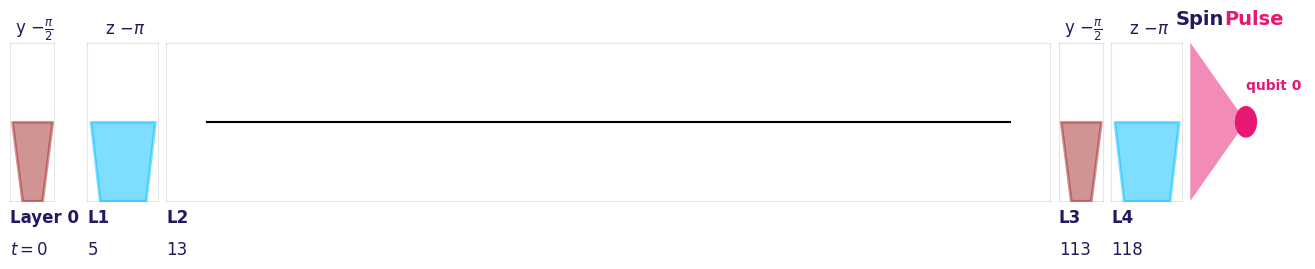

In [129]:
from spin_pulse.ramsey import get_ramsey_circuit

duration = 100
ramsey_circuit = get_ramsey_circuit(duration, hardware_specs)
ramsey_circuit.plot(hardware_specs)

Let us now consider the noisy version of a Ramsey circuit by assigning a noisy time trace of our experimental environment

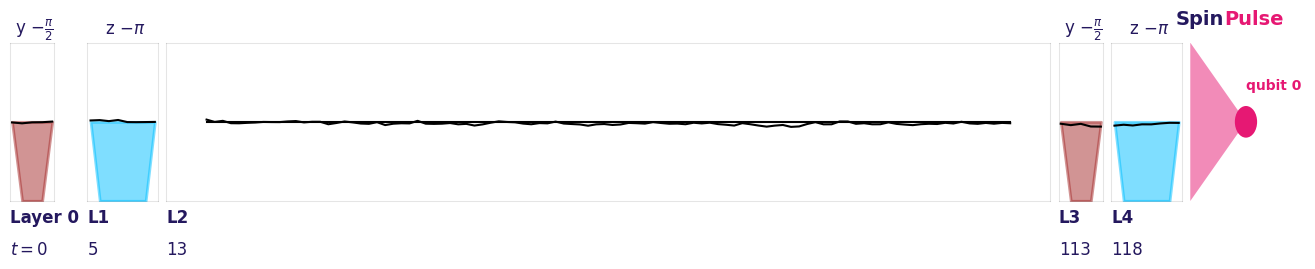

In [130]:
ramsey_circuit = get_ramsey_circuit(duration, hardware_specs, exp_env=exp_env)
ramsey_circuit.plot(hardware_specs)

We can produce  noisy iterations of the circuit by calling function ``assign_time_trace'' repeatedly.
Internally, a variable `t_lab` is used to attach the different time_traces fragments from our experimental environment, and incremented by each circuit duration. This mimicks an experimental sequence, where a list of circuits is executed sequentially.

Lab time after first time_trace assignment 126
Lab time after first time_trace assignment 252 ...


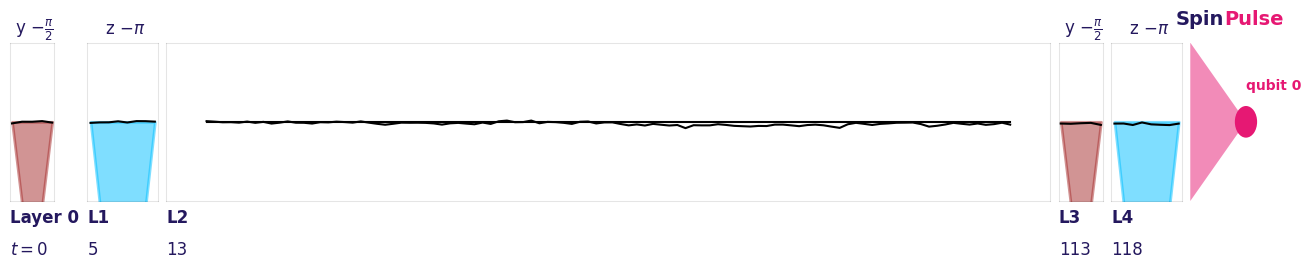

In [131]:
print("Lab time after first time_trace assignment", ramsey_circuit.t_lab)
ramsey_circuit.attach_time_traces(exp_env)
print("Lab time after first time_trace assignment", ramsey_circuit.t_lab, "...")
ramsey_circuit.plot()

The number of availables time trace fragments, which we call samples, is the integer part of the duration of the model divided by the duration of the circuit.

In [132]:
print(
    "Number of experimentally available samples ",
    ramsey_circuit.circuit_samples(exp_env),
)

Number of experimentally available samples  2080


Using the function `get_average_ramsey_contrast`, we repeat the circuit over such multiple samples and calculate the average contrast. This uses the function `averaging_over_samples` that can be used to calculate any averaged quantity of a given function of a pulse_circuit (here the Ramsey contrast).

Here the contrast corresponds to the expectation value of the $X$ operator after the idle sequence, and can be obtained from computational basis measurements after the second Hamard gate.

In [133]:
from spin_pulse.ramsey import get_average_ramsey_contrast

durations = np.arange(30, 300, 40, dtype=int)
average_contrast = get_average_ramsey_contrast(hardware_specs, exp_env, durations)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


We can compare with the function `plot_ramsey_contrast` which directly integrates the timetrace values, and also compare with approximate analytical expressions, functions of $T_2$ (that we recall in our publication).

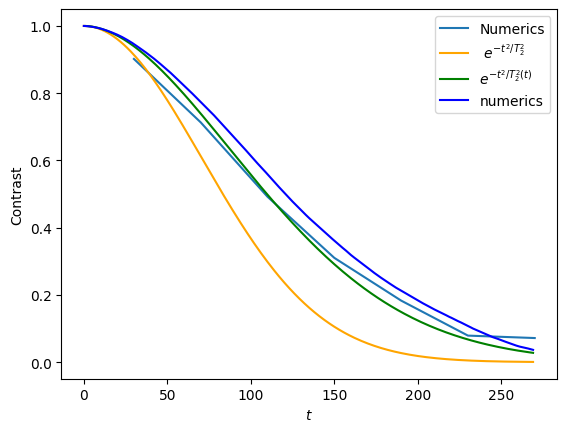

In [141]:
import matplotlib.pyplot as plt

plt.plot(durations, average_contrast, "-", label="Numerics")
exp_env.time_traces[0].plot_ramsey_contrast(durations[-1])
plt.xlabel("$t$")
plt.ylabel("Contrast")
plt.legend(loc=0)

## Spin Echo

Given an Idle time period, we can add two X pulses to remove low-frequency drifts, and `refocus' our Ramsey signal. The spin-echo sequence can be chosen by redefining our hardware_specs variable.

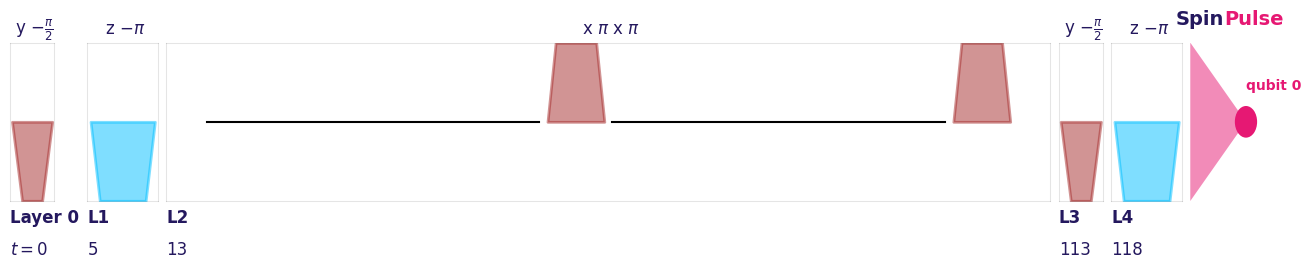

In [ ]:
hardware_specs_se = HardwareSpecs(
    num_qubits,
    B_field,
    delta,
    J_coupling,
    Shape.SQUARE,
    dynamical_decoupling="spin_echo",
)
spinecho_circuit = get_ramsey_circuit(duration, hardware_specs_se)
spinecho_circuit.plot(hardware_specs)

In [136]:
average_spinecho_contrast = get_average_ramsey_contrast(
    hardware_specs_se, exp_env, durations
)

100%|██████████| 7/7 [00:54<00:00,  7.84s/it]


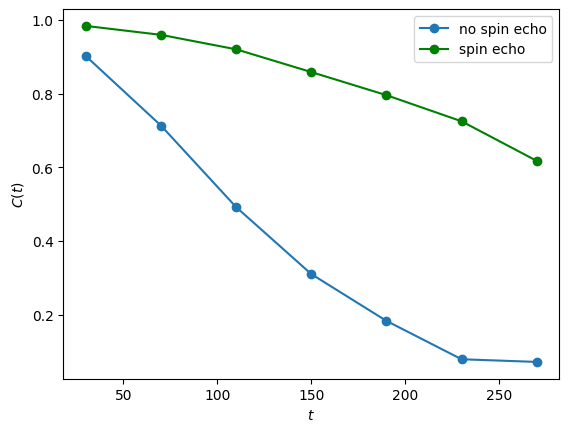

In [137]:
plt.plot(durations, average_contrast, "-o", label="no spin echo")
plt.plot(durations, average_spinecho_contrast, "-o", label="spin echo", color="green")
plt.xlabel("$t$")
plt.ylabel("$C(t)$")
plt.legend(loc=0)

## Full-drive dynamical decoupling

The spin-echo does not remove high-frequency components of the noise signal. 
To improve on that, we can use a ``full-drive'' dynamical decoupling sequence where the qubit is subject to a constant $X$ field that integrates to a multiple of $2\pi$. 

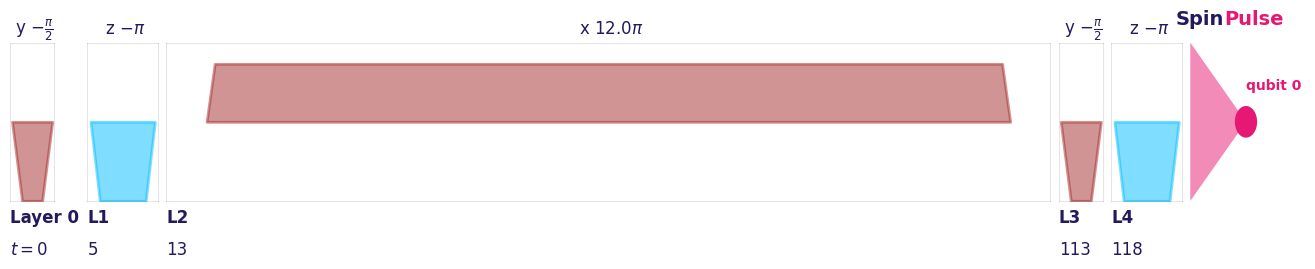

In [ ]:
hardware_specs_fd = HardwareSpecs(
    1,
    B_field,
    delta,
    J_coupling,
    Shape.SQUARE,
    dynamical_decoupling="full_drive",
)
fulldrive_circuit = get_ramsey_circuit(duration, hardware_specs_fd)
fulldrive_circuit.plot(hardware_specs)

In [139]:
average_fulldrive_contrast = get_average_ramsey_contrast(
    hardware_specs_fd, exp_env, durations
)

100%|██████████| 7/7 [00:54<00:00,  7.73s/it]


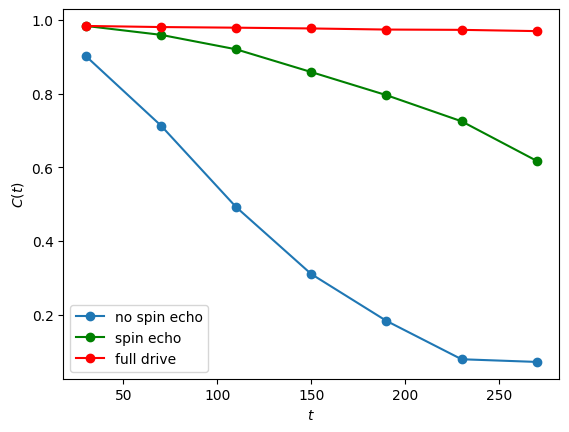

In [140]:
plt.plot(durations, average_contrast, "-o", label="no spin echo")
plt.plot(durations, average_spinecho_contrast, "-o", label="spin echo", color="green")
plt.plot(durations, average_fulldrive_contrast, "-o", label="full drive", color="red")


plt.xlabel("$t$")
plt.ylabel("$C(t)$")
plt.legend(loc=0)